
# Letroso: Simulation & Performance Analysis

**Course:** Simulation and Performance Analysis • **Project:** Wordle-like game (Letroso) simulator with enhanced hints (adjacency/order + first/last).

This notebook provides a clean, reproducible pipeline to **simulate players** under multiple policies, **compute metrics** (win rate, attempts distribution, CIs), and **compare theory vs. empirical** results for a random-guess baseline.

**Dictionary location:** `data/dict.txt` (UTF-8, one word per line).



## Game Rules & Extra Hints

- **Word length:** 4–10 letters (Portuguese alphabet; diacritics preserved).
- **Attempts:** up to 10 per game.
- **Feedback per position:**  
  - **Green** (correct letter, correct position),  
  - **Yellow** (correct letter, wrong position),  
  - **Gray** (letter not in word, considering multiplicity constraints).

**Extra hints (Letroso extensions used here):**
- **Adjacency/Order:** For each *adjacent pair* (bigram) in the guess:
  - `connected` if that bigram appears contiguously in the secret;
  - `ordered_only` if both letters appear in the secret **in that order** but **not** contiguously;
  - `none` otherwise.
- **First/Last indicator:** Boolean flags showing whether the **first** and **last** letters of the guess match the true secret’s first and last letters, respectively.

> We model these hints as **informative signals** (positive and negative), and use them for candidate filtering and information gain (entropy) calculations.


In [ ]:
# Imports & Globals
from __future__ import annotations

import math
import random
import statistics
from dataclasses import dataclass
from typing import Dict, List, Tuple, Iterable, Optional
from collections import Counter, defaultdict
from pathlib import Path
from functools import lru_cache

import numpy as np
import pandas as pd
import unicodedata
import matplotlib.pyplot as plt

# Display settings
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

RNG = random.Random(2025)
NP_RNG = np.random.default_rng(2025)

DICT_PATH = Path("data/dict.txt")  # Final dictionary provided by the user
MAX_ATTEMPTS = 10



## Dictionary Loading

Loads `data/dict.txt`. The loader performs **NFC normalization** (to keep composed characters) and **validates** that words are 4–10 letters, contain no hyphens/apostrophes, and start with lowercase (no proper names). If a word violates a rule it is dropped (with counts reported).


In [2]:

# Dictionary loading and validation

LETTER_ONLY_4_10 = r'^[^\W\d_]{4,10}$'  # Unicode letters only, length 4..10

DISALLOWED = set([
    "-", "–", "—", "‒", "―",   # hyphen/dash variants
    "'", "’", "‘", "ʼ", "ʹ"    # apostrophes
])

def has_disallowed_chars(s: str) -> bool:
    return any(ch in DISALLOWED for ch in s)

def load_dictionary(path: Path) -> List[str]:
    if not path.exists():
        raise FileNotFoundError(f"Dictionary not found at {path}. Please ensure data/dict.txt exists.")
    kept, skipped = 0, 0
    out: List[str] = []
    seen = set()
    import re
    pattern = re.compile(LETTER_ONLY_4_10, re.UNICODE)
    with path.open("r", encoding="utf-8") as f:
        for raw in f:
            w = raw.strip()
            if not w:
                continue
            w = unicodedata.normalize("NFC", w)
            # Basic validations (idempotent with your preprocessing; safe if dict already filtered)
            if w[0].isupper():
                skipped += 1
                continue
            if has_disallowed_chars(w):
                skipped += 1
                continue
            if not pattern.match(w):
                skipped += 1
                continue
            if w not in seen:
                out.append(w)
                seen.add(w)
                kept += 1
    print(f"Dictionary loaded. Kept: {kept} | Skipped (during validation): {skipped}")
    return out

try:
    WORDS = load_dictionary(DICT_PATH)
except FileNotFoundError as e:
    WORDS = []
    print(e)
    
len(WORDS), WORDS[:10]


Dictionary loaded. Kept: 165402 | Skipped (during validation): 0


(165402,
 ['aabora',
  'aaleniano',
  'aaleniense',
  'aalênio',
  'aalense',
  'aaquenense',
  'aaquênio',
  'aardvark',
  'aariano',
  'aarônico'])


## Feedback Engine

We compute:
1. **Positional colors** (`G`/`Y`/`B`) with duplicate-handling like Wordle.
2. **Adjacency & order** for adjacent pairs (bigrams) in the guess:
   - `connected`: the bigram occurs contiguously in the secret;
   - `ordered_only`: letters appear in order but not contiguously;
   - `none`: neither.
3. **First/Last** correctness booleans.


In [3]:

@dataclass(frozen=True)
class ExtraHint:
    bigram_hints: Tuple[str, ...]  # each in {"connected","ordered_only","none"}
    first_is_correct: bool
    last_is_correct: bool

@dataclass(frozen=True)
class Feedback:
    colors: Tuple[str, ...]
    extra: ExtraHint

    def signature(self) -> str:
        return '|'.join([
            ''.join(self.colors),
            ','.join(self.extra.bigram_hints),
            'F1' if self.extra.first_is_correct else 'F0',
            'L1' if self.extra.last_is_correct else 'L0'
        ])


def wordle_colors(secret: str, guess: str) -> Tuple[str, ...]:
    """
    Unicode-aware Wordle coloring that works even when lengths differ.
    - Greens only for overlapping indices where s[i] == g[i].
    - Yellows use multiplicity from secret minus greens.
    - Non-overlapping positions in guess can be Y (if the letter exists among the remaining)
      or B otherwise. Positions beyond secret can never be G.
    Returns a tuple of length len(guess).
    """
    Ls, Lg = len(secret), len(guess)
    res = ['B'] * Lg
    scount = Counter(secret)

    # First pass: greens only where both indices exist
    minL = min(Ls, Lg)
    for i in range(minL):
        if secret[i] == guess[i]:
            res[i] = 'G'
            scount[guess[i]] -= 1

    # Second pass: yellows across the entire guess (including indices >= Ls)
    for i, g in enumerate(guess):
        if res[i] == 'G':
            continue
        if scount[g] > 0:
            res[i] = 'Y'
            scount[g] -= 1
        else:
            res[i] = 'B'
    return tuple(res)

def bigram_hint_for(secret: str, a: str, b: str) -> str:
    """Return 'connected', 'ordered_only', or 'none' for bigram (a,b)."""
    # Connected if substring ab occurs
    if a + b in secret:
        return "connected"
    # Ordered only if there exists i<j with secret[i]==a and secret[j]==b, but not adjacent
    positions_a = [i for i, ch in enumerate(secret) if ch == a]
    positions_b = [i for i, ch in enumerate(secret) if ch == b]
    for i in positions_a:
        for j in positions_b:
            if i < j and j != i + 1:
                return "ordered_only"
    return "none"

def adjacency_order_hints(secret: str, guess: str) -> Tuple[str, ...]:
    if len(guess) < 2:
        return tuple()
    hints = []
    for i in range(len(guess) - 1):
        a, b = guess[i], guess[i+1]
        hints.append(bigram_hint_for(secret, a, b))
    return tuple(hints)

def compute_feedback(secret: str, guess: str) -> Feedback:
    # Colors are now defined for any lengths
    colors = wordle_colors(secret, guess)
    bigrams = adjacency_order_hints(secret, guess)  # fine for any lengths
    first_correct = (len(secret) > 0 and len(guess) > 0 and guess[0] == secret[0])
    last_correct  = (len(secret) > 0 and len(guess) > 0 and guess[-1] == secret[-1])
    return Feedback(
        colors=colors,
        extra=ExtraHint(
            bigram_hints=bigrams,
            first_is_correct=first_correct,
            last_is_correct=last_correct
        )
    )


## Candidate Filtering

Given a past guess and its feedback, we keep only candidates that are consistent with:
- **Positional constraints** (greens fixed, yellows excluded from those positions) and **letter-count bounds** derived from colors.
- **Adjacency/order** hints for each bigram in the guess.
- **First/Last** booleans (enforced both positively and negatively).


In [4]:

def consistent_with_colors(candidate: str, guess: str, colors: Tuple[str, ...]) -> bool:
    """Check standard Wordle constraints, including multiplicity.

    Implementation uses per-letter min/max counts derived from (guess, colors)."""
    # Greens fix positions
    for i, c in enumerate(colors):
        if c == 'G' and candidate[i] != guess[i]:
            return False
        if c == 'Y' and candidate[i] == guess[i]:
            return False

    # Compute min/max occurrences per letter
    # min_count = number of G+Y for that letter in guess
    # max_count = number of positions not marked B for that letter (upper bound)
    min_req = Counter()
    max_cap = defaultdict(lambda: float('inf'))

    guess_counts = Counter(guess)
    colored_counts = Counter()
    # First pass: count required mins
    for i, (gch, col) in enumerate(zip(guess, colors)):
        if col in ('G', 'Y'):
            min_req[gch] += 1
            colored_counts[gch] += 1

    # Second: compute max cap. If a letter has any 'B', cap it at the count of (G+Y) observed.
    for ch in guess_counts:
        num_GY = sum(1 for i, c in enumerate(colors) if guess[i] == ch and c in ('G','Y'))
        num_not_B = sum(1 for i, c in enumerate(colors) if guess[i] == ch and c != 'B')
        num_B = guess_counts[ch] - num_not_B
        if num_B > 0:
            # Letter appears at most num_GY times in the secret
            max_cap[ch] = num_GY
        else:
            # No cap beyond total length
            max_cap[ch] = float('inf')

    cand_counts = Counter(candidate)
    # Enforce mins
    for ch, m in min_req.items():
        if cand_counts[ch] < m:
            return False
    # Enforce max
    for ch, cap in max_cap.items():
        if cand_counts[ch] > cap:
            return False

    return True

def bigram_order_holds(word: str, a: str, b: str) -> bool:
    """True if word contains a before b (not necessarily adjacent)."""
    indices_a = [i for i, ch in enumerate(word) if ch == a]
    indices_b = [i for i, ch in enumerate(word) if ch == b]
    for i in indices_a:
        for j in indices_b:
            if i < j:
                return True
    return False

def consistent_with_extra(candidate: str, guess: str, extra: ExtraHint) -> bool:
    # First/Last indicators (both positive and negative constraints)
    if len(guess) >= 1:
        if extra.first_is_correct and candidate[0] != guess[0]:
            return False
        if not extra.first_is_correct and candidate[0] == guess[0]:
            return False
        if extra.last_is_correct and candidate[-1] != guess[-1]:
            return False
        if not extra.last_is_correct and candidate[-1] == guess[-1]:
            return False

    # Bigram hints
    for i, hint in enumerate(extra.bigram_hints):
        a, b = guess[i], guess[i+1]
        if hint == "connected":
            if a + b not in candidate:
                return False
        elif hint == "ordered_only":
            # Must be in order but not adjacent
            if (a + b) in candidate:
                return False
            if not bigram_order_holds(candidate, a, b):
                return False
        elif hint == "none":
            # No constraint
            pass
    return True

def filter_candidates(candidates: Iterable[str], guess: str, fb: Feedback) -> List[str]:
    colors = fb.colors
    extra = fb.extra
    out = []
    for cand in candidates:
        if len(cand) != len(guess):
            continue
        if not consistent_with_colors(cand, guess, colors):
            continue
        if not consistent_with_extra(cand, guess, extra):
            continue
        out.append(cand)
    return out



## Player Policies

- **RandomPolicy**: choose uniformly from the current candidate set.
- **EntropyPolicy**: choose the guess that maximizes expected information (Shannon entropy) over full feedback signatures. To keep runtime bounded, you can sample candidate secrets for scoring (parameter `secret_sample_size`).  
- **AdjacencyHeuristicPolicy**: prefer guesses that cover frequent letters and bigrams among candidates, plus diversity at first/last positions.


In [5]:
## Player Policies

class Policy:
    name: str = "Base"
    def select_guess(self, candidates: List[str], history: List[Tuple[str, 'Feedback']]) -> str:
        raise NotImplementedError

class RandomPolicy(Policy):
    name = "RAND"
    def select_guess(self, candidates: List[str], history: List[Tuple[str, 'Feedback']]) -> str:
        return RNG.choice(candidates)

def feedback_signature_for_guess_against_secrets(guess: str, secrets: List[str]) -> Dict[str, int]:
    buckets = defaultdict(int)
    for s in secrets:
        fb = compute_feedback(s, guess)
        buckets[fb.signature()] += 1
    return buckets

def shannon_entropy(counts: Dict[str, int]) -> float:
    total = sum(counts.values())
    if total == 0:
        return 0.0
    H = 0.0
    for c in counts.values():
        p = c / total
        H -= p * math.log2(p)
    return H

class EntropyPolicy(Policy):
    name = "ENTROPY"

    def __init__(self,
                 secret_sample_size: int = 500,
                 guess_subset: int = 300,
                 start_sample: int = 128,
                 top_k: int = 120,
                 cache_size: int = 400_000,
                 margin_bits: float = 0.02):
        self.max_sample = max(1, secret_sample_size)
        self.start_sample = max(1, min(start_sample, self.max_sample))
        self.guess_subset = max(1, guess_subset)
        self.top_k = max(1, top_k)
        self.margin_bits = float(margin_bits)
        self.secret_sample_size = self.max_sample  # back‑compat for FastEntropyPolicy, if you still use it

        @lru_cache(maxsize=cache_size)
        def _sig(secret: str, guess: str) -> str:
            # When lengths differ, Feedback.signature() will return 'LEN_MISMATCH'
            if len(secret) != len(guess):
                return "LEN_MISMATCH"
            return compute_feedback(secret, guess).signature()
        self._sig = _sig

    def _preselect_guess_pool(self, candidates: List[str]) -> List[str]:
        if len(candidates) <= self.guess_subset:
            return candidates
        letter_freq = Counter()
        first_freq = Counter()
        last_freq = Counter()
        bigram_freq = Counter()
        len_freq = Counter(len(w) for w in candidates)

        for w in candidates:
            letter_freq.update(set(w))
            first_freq[w[0]] += 1
            last_freq[w[-1]] += 1
            for i in range(len(w) - 1):
                bigram_freq[w[i:i+2]] += 1

        def score(word: str) -> float:
            letters = set(word)
            s = sum(letter_freq[ch] for ch in letters)
            s += first_freq[word[0]] + last_freq[word[-1]]
            for i in range(len(word) - 1):
                s += 0.25 * bigram_freq[word[i:i+2]]
            s -= 0.1 * sum(word.count(ch) - 1 for ch in letters)
            # tiny exploration bonus across lengths
            s += 0.05 / max(1, len_freq[len(word)])
            return float(s)

        return sorted(candidates, key=score, reverse=True)[: self.guess_subset]

    def _entropy_on_sample(self, guess: str, secrets_sample: List[str]) -> float:
        buckets = {}
        for s in secrets_sample:
            sig = self._sig(s, guess)  # 'LEN_MISMATCH' or full feedback signature
            buckets[sig] = buckets.get(sig, 0) + 1
        return shannon_entropy(buckets)

    def select_guess(self, candidates: List[str], history: List[Tuple[str, Optional['Feedback']]]) -> str:
        if not candidates:
            raise RuntimeError("EntropyPolicy received empty candidates.")

        # 1) Preselect guess pool from mixed-length candidates
        guess_pool = self._preselect_guess_pool(candidates)

        # 2) Mixed-length secrets pool (shuffle once -> stable progressive sampling)
        secrets_pool = list(candidates)
        RNG.shuffle(secrets_pool)

        # 3) Progressive widening
        sample_size = min(self.start_sample, len(secrets_pool))
        prev_best = None

        while True:
            secrets_sample = secrets_pool[:sample_size]

            ent = []
            for g in guess_pool:
                ent.append((self._entropy_on_sample(g, secrets_sample), g))
            ent.sort(reverse=True)
            best_H, best_guess = ent[0]
            second_H = ent[1][0] if len(ent) > 1 else -float("inf")
            margin = best_H - second_H

            # Shrink pool for next round
            guess_pool = [g for _, g in ent[: self.top_k]]

            stable = (prev_best == best_guess) and (margin >= self.margin_bits)
            if stable:
                return best_guess

            prev_best = best_guess
            if sample_size >= self.max_sample or sample_size >= len(secrets_pool):
                return best_guess

            sample_size = min(2 * sample_size, self.max_sample, len(secrets_pool))


class AdjacencyHeuristicPolicy(Policy):
    name = "ADJ-HEUR"
    def select_guess(self, candidates: List[str], history: List[Tuple[str, Optional['Feedback']]]) -> str:
        # Global stats across all current candidates (mixed lengths OK)
        letter_freq = Counter()
        first_freq = Counter()
        last_freq = Counter()
        bigram_freq = Counter()
        len_freq = Counter(len(w) for w in candidates)

        for w in candidates:
            letter_freq.update(set(w))      # set() => coverage, not repetition
            first_freq[w[0]] += 1
            last_freq[w[-1]] += 1
            for i in range(len(w) - 1):
                bigram_freq[w[i:i+2]] += 1

        def score(word: str) -> float:
            letters = set(word)
            s = sum(letter_freq[ch] for ch in letters)
            s += first_freq[word[0]] + last_freq[word[-1]]
            for i in range(len(word) - 1):
                s += 0.5 * bigram_freq[word[i:i+2]]
            # Mild penalty for internal duplicates (exploration)
            s -= 0.2 * sum(word.count(ch) - 1 for ch in letters)
            # NEW: tiny bonus for probing less-tested lengths early
            s += 0.1 / max(1, len_freq[len(word)])
            return float(s)

        return max(candidates, key=score)




## Game Simulation

We simulate one game by iteratively selecting a guess via the chosen policy, receiving feedback, and filtering candidates until success or we hit the attempt limit.


In [6]:

@dataclass
class GameResult:
    secret: str
    success: bool
    attempts: int
    transcript: List[Tuple[str, Optional[Feedback]]]

def simulate_one_game(secret: str, policy: Policy, dictionary: List[str],
                      use_hints: bool = True, max_attempts: int = MAX_ATTEMPTS) -> GameResult:
    """
    Players do NOT know the secret length initially.
    - Candidates start as the full dictionary (all lengths 4..10).
    - If a guess has the wrong length, the player only learns 'wrong length':
      we remove that guess AND eliminate all words of that (wrong) length.
    - The first time a guess matches the secret's length, the player implicitly learns
      the true length; from then on we restrict to that length and apply feedback filtering.
    """
    candidates = list(dictionary)          # all lengths initially
    history: List[Tuple[str, Optional[Feedback]]] = []
    secret_len = len(secret)
    length_learned = False                 # becomes True after the first same-length guess

    for t in range(1, max_attempts + 1):
        if not candidates:  # extremely unlikely, but guard anyway
            candidates = list(dictionary)

        guess = policy.select_guess(candidates, history)

        # Case A: wrong length -> only 'wrong length' info; no colors/hints
        if len(guess) != secret_len:
            fb = compute_feedback(secret, guess)  # now safe for any lengths
            history.append((guess, fb))
            wrong_len = len(guess)
            # eliminate all words of this length from candidates
            candidates = [w for w in candidates if len(w) != wrong_len]
            continue

        # Case B: correct length -> standard feedback (colors + optional extra hints)
        fb = compute_feedback(secret, guess) if use_hints else Feedback(
            colors=wordle_colors(secret, guess),
            extra=ExtraHint(
                bigram_hints=tuple("none" for _ in range(max(0, secret_len - 1))),
                first_is_correct=False,
                last_is_correct=False
            )
        )
        history.append((guess, fb))

        if guess == secret:
            return GameResult(secret=secret, success=True, attempts=t, transcript=history)

        # From now on, secret length is implicitly known
        length_learned = True

        # Restrict to the known length, then filter
        same_len_pool = [w for w in candidates if len(w) == secret_len]
        if use_hints:
            candidates = filter_candidates(same_len_pool, guess, fb)
        else:
            # No-hints baseline: just avoid repeating the same word, but keep the known length
            candidates = [w for w in same_len_pool if w != guess]

    return GameResult(secret=secret, success=False, attempts=max_attempts, transcript=history)



## Experiment Runner
Run many games and collect metrics into a DataFrame.


In [7]:

def run_experiment(policy: Policy, dictionary: List[str], num_games: int = 1000,
                   use_hints: bool = True, seed: int = 2025,
                   lengths: Optional[Iterable[int]] = None) -> pd.DataFrame:
    RNG.seed(seed)
    secrets_pool = dictionary
    if lengths is not None:
        lengths = set(lengths)
        secrets_pool = [w for w in dictionary if len(w) in lengths]
    if not secrets_pool:
        raise ValueError("No words available for the selected lengths.")

    rows = []
    for i in range(num_games):
        secret = RNG.choice(secrets_pool)
        res = simulate_one_game(secret, policy, dictionary, use_hints=use_hints)
        rows.append({
            "secret": res.secret,
            "success": res.success,
            "attempts": res.attempts,
            "policy": policy.name,
            "use_hints": use_hints
        })
    return pd.DataFrame(rows)



## Metrics & Confidence Intervals

We report:
- **Win rate** with a **Wilson 95% CI**.
- **Mean attempts (overall)** with a **t-interval**.
- **Mean attempts among wins** with a **t-interval**.


In [8]:

from math import sqrt
from scipy import stats

def wilson_ci(successes: int, n: int, conf: float = 0.95) -> Tuple[float, float]:
    if n == 0:
        return (0.0, 0.0)
    z = stats.norm.ppf(0.5 + conf/2)
    phat = successes / n
    denom = 1 + z*z/n
    center = (phat + z*z/(2*n)) / denom
    half = z * math.sqrt((phat*(1-phat) + z*z/(4*n))/n) / denom
    return (max(0.0, center - half), min(1.0, center + half))

def t_ci_mean(data: List[float], conf: float = 0.95) -> Tuple[float, float]:
    n = len(data)
    if n <= 1:
        return (float('nan'), float('nan'))
    mean = float(np.mean(data))
    sd = float(np.std(data, ddof=1))
    tcrit = stats.t.ppf(0.5 + conf/2, df=n-1)
    half = tcrit * sd / math.sqrt(n)
    return (mean - half, mean + half)

def summarize_results(df: pd.DataFrame) -> pd.DataFrame:
    out_rows = []
    for (policy, use_hints), g in df.groupby(["policy", "use_hints"]):
        n = len(g)
        s = int(g["success"].sum())
        wr = s / n if n else float('nan')
        wr_lo, wr_hi = wilson_ci(s, n)
        mean_all = float(g["attempts"].mean())
        ci_all = t_ci_mean(g["attempts"].tolist())
        wins = g[g["success"]]
        mean_wins = float(wins["attempts"].mean()) if len(wins) else float('nan')
        ci_wins = t_ci_mean(wins["attempts"].tolist()) if len(wins) > 1 else (float('nan'), float('nan'))
        out_rows.append({
            "policy": policy,
            "use_hints": use_hints,
            "n_games": n,
            "wins": s,
            "win_rate": wr,
            "win_rate_95CI_low": wr_lo,
            "win_rate_95CI_high": wr_hi,
            "mean_attempts_all": mean_all,
            "mean_attempts_all_95CI_low": ci_all[0],
            "mean_attempts_all_95CI_high": ci_all[1],
            "mean_attempts_wins": mean_wins,
            "mean_attempts_wins_95CI_low": ci_wins[0],
            "mean_attempts_wins_95CI_high": ci_wins[1],
        })
    return pd.DataFrame(out_rows).sort_values(["use_hints","policy"]).reset_index(drop=True)



## Theory vs Empirical (Baseline)

For **random guessing with replacement** and **no hints**, if the dictionary has size \(|D|\),  
the probability of success within \(k\) guesses is:
\[ P(T \le k) = 1 - (1 - 1/|D|)^k. \]

We compare this to an empirical simulation using the **RandomPolicy** with `use_hints=False`, and guesses drawn uniformly from **all words of the same length as the secret** (with replacement effect approximated by ignoring any filtering).


In [9]:

def analytic_cdf(k: int, D: int) -> float:
    return 1.0 - (1.0 - 1.0/D) ** k

def empirical_cdf_attempts(df: pd.DataFrame) -> List[float]:
    # df should contain games from a no-hints random experiment
    counts = Counter(df["attempts"])
    n = len(df)
    cdf = []
    cum = 0
    for k in range(1, MAX_ATTEMPTS + 1):
        cum += counts.get(k, 0)
        cdf.append(cum / n)
    return cdf

def plot_cdf_comparison(df_nohints: pd.DataFrame, D_estimate: int):
    # Compute empirical CDF of attempts (success or fail at MAX_ATTEMPTS)
    emp = empirical_cdf_attempts(df_nohints)
    ks = list(range(1, MAX_ATTEMPTS + 1))
    ana = [analytic_cdf(k, D_estimate) for k in ks]

    plt.figure()
    plt.plot(ks, emp, label="Empirical CDF (RAND, no hints)")
    plt.plot(ks, ana, label=f"Analytic CDF (|D|≈{D_estimate})", linestyle="--")
    plt.xlabel("Attempts (k)")
    plt.ylabel("P(T ≤ k)")
    plt.title("Theory vs Empirical CDF (Random guessing, no hints)")
    plt.legend()
    plt.grid(True)
    plt.show()



## Unit Tests (Feedback Engine)

A few sanity checks to validate core feedback logic (colors + adjacency/order + first/last).


In [10]:
def run_unit_tests():
    # Basic colors
    assert wordle_colors("casa", "casa") == tuple("GGGG")
    assert wordle_colors("casa", "cabo") == tuple("GGBB")   # 2 greens, then 2 grays
    # Duplicate handling
    assert wordle_colors("bala", "ball") == tuple("GGGB")   # last 'l' exceeds count

    # Adjacency/order tests with secret = "ideal"
    secret = "ideal"

    # Use a 5-letter guess: "model" -> bigrams: mo, od, de, el
    # Only 'de' is connected; 'el' is ordered-only (e before l in "ideal", not adjacent)
    g = "model"
    fb = compute_feedback(secret, g)
    assert fb.extra.bigram_hints == ("none", "none", "connected", "ordered_only")
    assert fb.extra.first_is_correct is False   # m != i
    assert fb.extra.last_is_correct is True     # l == l

    # "trial" -> bigrams: tr, ri, ia, al
    # 'ia' is ordered-only; 'al' is connected in "ideal"
    g2 = "trial"
    fb2 = compute_feedback(secret, g2)
    assert fb2.extra.bigram_hints[2] == "ordered_only"
    assert fb2.extra.bigram_hints[3] == "connected"
    assert fb2.extra.first_is_correct is False  # t != i
    assert fb2.extra.last_is_correct is True    # l == l

    print("All unit tests passed.")

run_unit_tests()


All unit tests passed.



## Quick Demo (Small Sample)

Set `RUN_DEMO = True` to run a quick demo with a small number of games (uses `data/dict.txt`).  
Adjust `NUM_GAMES` if you want a larger demo run inside the notebook.


Policies:   0%|          | 0/4 [00:00<?, ?it/s]

RAND (hints):   0%|          | 0/200 [00:00<?, ?it/s]

ENTROPY* (hints):   0%|          | 0/200 [00:00<?, ?it/s]

ADJ-HEUR (hints):   0%|          | 0/200 [00:00<?, ?it/s]

RAND (no-hints):   0%|          | 0/200 [00:00<?, ?it/s]

,policy,use_hints,n_games,wins,win_rate,win_rate_95CI_low,win_rate_95CI_high,mean_attempts_all,mean_attempts_all_95CI_low,mean_attempts_all_95CI_high,mean_attempts_wins,mean_attempts_wins_95CI_low,mean_attempts_wins_95CI_high
0,RAND,False,200,0,0.000,1.734723e-18,0.018845,10.000,10.000000,10.000000,NaN,NaN,NaN
1,ADJ-HEUR,True,200,168,0.840,7.828593e-01,0.884326,9.020,8.902245,9.137755,8.833333,8.712364,8.954303
2,ENTROPY*,True,200,170,0.850,7.939442e-01,0.892864,9.095,8.976718,9.213282,8.935294,8.810785,9.059804
3,RAND,True,200,157,0.785,7.229769e-01,0.836281,8.480,8.219243,8.740757,8.063694,7.762523,8.364865


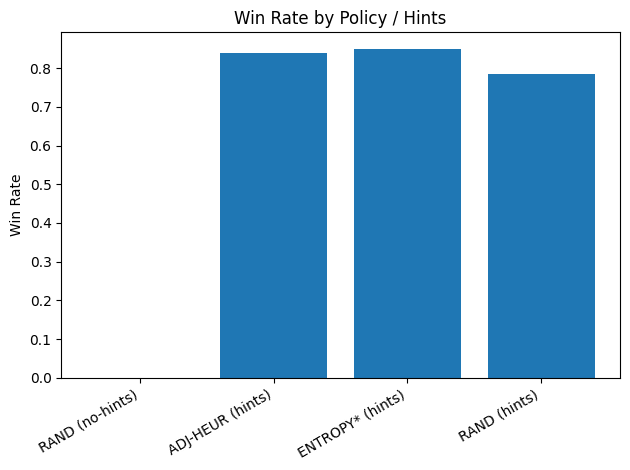

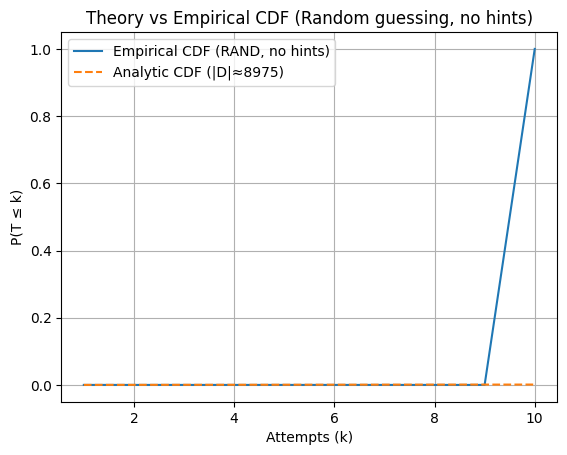

In [11]:
# Progress-enabled demo run with a faster Entropy policy + safe tqdm import
try:
    from tqdm.auto import tqdm  # widget if available
except Exception:
    from tqdm import tqdm       # plain-text fallback

from IPython.display import display
from functools import lru_cache
from collections import Counter

# ---- Fast entropy policy (subset + caching) ----
class FastEntropyPolicy(EntropyPolicy):
    name = "ENTROPY*"
    def __init__(self, secret_sample_size: int = 300, guess_subset: int = 300, cache_size: int = 200_000):
        super().__init__(secret_sample_size=secret_sample_size)
        self.guess_subset = guess_subset

        # Local cached wrapper returning the signature only (lighter to store)
        @lru_cache(maxsize=cache_size)
        def _sig(s: str, g: str) -> str:
            return compute_feedback(s, g).signature()
        self._feedback_sig = _sig

    def _preselect_guess_pool(self, candidates):
        """Heuristic: choose up to guess_subset candidates that maximize letter/bigram coverage and boundary variety."""
        if len(candidates) <= self.guess_subset:
            return candidates

        # lightweight scoring (no big loops)
        letter_freq = Counter()
        first_freq = Counter()
        last_freq = Counter()
        bigram_freq = Counter()
        for w in candidates:
            letter_freq.update(set(w))
            first_freq[w[0]] += 1
            last_freq[w[-1]] += 1
            for i in range(len(w) - 1):
                bigram_freq[w[i:i+2]] += 1

        def score(word: str) -> float:
            letters = set(word)
            s = sum(letter_freq[ch] for ch in letters)
            s += first_freq[word[0]] + last_freq[word[-1]]
            for i in range(len(word) - 1):
                s += 0.25 * bigram_freq[word[i:i+2]]  # lighter weight than heuristic policy
            s -= 0.1 * sum(word.count(ch) - 1 for ch in letters)  # small penalty for dup letters
            return float(s)

        # Pick top-K by score
        return sorted(candidates, key=score, reverse=True)[: self.guess_subset]

    def select_guess(self, candidates, history):
        # Secret sample for entropy
        if len(candidates) <= self.secret_sample_size:
            secrets = candidates
        else:
            secrets = RNG.sample(candidates, self.secret_sample_size)

        # Reduce guess pool to a manageable subset
        guess_pool = self._preselect_guess_pool(candidates)

        best_guess, best_H = None, -1.0
        for g in guess_pool:
            # Use cached signatures
            buckets = {}
            for s in secrets:
                sig = self._feedback_sig(s, g)
                buckets[sig] = buckets.get(sig, 0) + 1
            H = shannon_entropy(buckets)
            if H > best_H:
                best_H, best_guess = H, g

        return best_guess if best_guess is not None else RNG.choice(candidates)

# ---- Progress helpers ----
def run_experiment_progress(policy, dictionary, num_games=1000, use_hints=True, seed=2025,
                            lengths=None, desc=""):
    """Same as run_experiment, but with a per-game tqdm progress bar and KeyboardInterrupt safety."""
    RNG.seed(seed)
    secrets_pool = dictionary
    if lengths is not None:
        lengths = set(lengths)
        secrets_pool = [w for w in dictionary if len(w) in lengths]
    if not secrets_pool:
        raise ValueError("No words available for the selected lengths.")

    rows = []
    try:
        for _ in tqdm(range(num_games), desc=desc, leave=False, position=1):
            secret = RNG.choice(secrets_pool)
            res = simulate_one_game(secret, policy, dictionary, use_hints=use_hints)
            rows.append({
                "secret": res.secret,
                "success": res.success,
                "attempts": res.attempts,
                "policy": policy.name,
                "use_hints": use_hints
            })
    except KeyboardInterrupt:
        # Return partial results so you don't lose progress
        pass
    return pd.DataFrame(rows)

# ---- Demo parameters ----
RUN_DEMO = True
NUM_GAMES = 200   # adjust as needed for the demo
LENGTHS   = [5]  # typical length; change or set to None for all lengths

if RUN_DEMO:
    if not WORDS:
        raise RuntimeError("Dictionary failed to load. Ensure data/dict.txt exists and rerun the loader cell.")

    # Policies
    rand = RandomPolicy()
    ent  = FastEntropyPolicy(secret_sample_size=250, guess_subset=250)  # tuned for speed
    adj  = AdjacencyHeuristicPolicy()

    # Plan & outer progress
    dfs = []
    plan = [
        ("RAND (hints)",      rand, True,  2025),
        ("ENTROPY* (hints)",  ent,  True,  2026),
        ("ADJ-HEUR (hints)",  adj,  True,  2027),
        ("RAND (no-hints)",   rand, False, 2028),
    ]

    with tqdm(total=len(plan), desc="Policies", position=0) as pbar:
        for name, pol, use_hints, seed in plan:
            dfp = run_experiment_progress(
                pol, WORDS, num_games=NUM_GAMES, use_hints=use_hints,
                seed=seed, lengths=LENGTHS, desc=name
            )
            dfs.append(dfp)
            pbar.update(1)

    # Aggregate results
    df_hints   = pd.concat(dfs[:3], ignore_index=True)
    df_rand_no = dfs[3]
    summary = summarize_results(pd.concat([df_hints, df_rand_no], ignore_index=True))

    # Display summary
    try:
        from ace_tools import display_dataframe_to_user
        display_dataframe_to_user("Letroso — Demo Summary", summary)
    except Exception:
        display(summary)

    # Plots
    # 1) Win rate by policy
    plt.figure()
    order, wrates = [], []
    for _, row in summary.iterrows():
        order.append(f"{row['policy']} ({'hints' if row['use_hints'] else 'no-hints'})")
        wrates.append(row["win_rate"])
    plt.bar(order, wrates)
    plt.xticks(rotation=30, ha='right')
    plt.ylabel("Win Rate")
    plt.title("Win Rate by Policy / Hints")
    plt.tight_layout()
    plt.show()

    # 2) Theory vs Empirical CDF for no-hints random baseline
    if LENGTHS is None:
        D_est = len(WORDS)
    else:
        pool = [w for w in WORDS if len(w) in set(LENGTHS)]
        D_est = max(1, len(pool))
    plot_cdf_comparison(df_rand_no, D_estimate=D_est)



## Full Run (Recommended)

1. Ensure `data/dict.txt` exists and is properly filtered (4–10 letters, no hyphens/apostrophes, no proper names).
2. Choose **lengths** (e.g., `[5]` for 5-letter words, or `None` for all 4–10).
3. Set `NUM_GAMES` per policy (e.g., 10_000 for robust CIs).
4. Tune `secret_sample_size` in `EntropyPolicy` if runtime is high.

> You can also save all results to CSV for your report.


In [ ]:
# === Full Run Template (with progress bars and faster entropy if available) ===
try:
    from tqdm.auto import tqdm  # rich widget if available
except Exception:
    from tqdm import tqdm       # plain-text fallback

from IPython.display import display
from pathlib import Path
import matplotlib.pyplot as plt

# ---- Parameters ----
FULL_NUM_GAMES = 2000          # total games per policy
FULL_LENGTHS   = [5]           # e.g., [5] or None for 4..10
ENT_SECRET_SAMPLE_SIZE = 600   # for EntropyPolicy / FastEntropyPolicy
ENT_GUESS_SUBSET       = 600   # used only if FastEntropyPolicy is available
ENT_CACHE_SIZE         = 300_000  # used only if FastEntropyPolicy is available

if not WORDS:
    raise RuntimeError("Dictionary failed to load. Ensure data/dict.txt exists and rerun the loader cell.")

# ---- Policy instances (use FastEntropyPolicy if it's defined) ----
rand = RandomPolicy()
if 'FastEntropyPolicy' in globals():
    ent  = FastEntropyPolicy(secret_sample_size=ENT_SECRET_SAMPLE_SIZE,
                             guess_subset=ENT_GUESS_SUBSET,
                             cache_size=ENT_CACHE_SIZE)
else:
    ent  = EntropyPolicy(secret_sample_size=ENT_SECRET_SAMPLE_SIZE)
adj  = AdjacencyHeuristicPolicy()

# ---- Progress-enabled experiment runner ----
def run_experiment_progress(policy, dictionary, num_games=1000, use_hints=True, seed=2025,
                            lengths=None, desc=""):
    """Same as run_experiment, but with a per-game tqdm progress bar and KeyboardInterrupt safety."""
    RNG.seed(seed)
    secrets_pool = dictionary
    if lengths is not None:
        lengths = set(lengths)
        secrets_pool = [w for w in dictionary if len(w) in lengths]
    if not secrets_pool:
        raise ValueError("No words available for the selected lengths.")

    rows = []
    try:
        for _ in tqdm(range(num_games), desc=desc, leave=False, position=1):
            secret = RNG.choice(secrets_pool)
            res = simulate_one_game(secret, policy, dictionary, use_hints=use_hints)
            rows.append({
                "secret": res.secret,
                "success": res.success,
                "attempts": res.attempts,
                "policy": policy.name,
                "use_hints": use_hints
            })
    except KeyboardInterrupt:
        # Return partial results so you don't lose progress
        pass
    return pd.DataFrame(rows)

# ---- Plan & execution with outer progress bar ----
dfs = []
plan = [
    ("RAND (hints)",      rand, True,  2025),
    ("ENTROPY (hints)" if ent.__class__.__name__ == "EntropyPolicy" else "ENTROPY* (hints)", ent,  True,  2026),
    ("ADJ-HEUR (hints)",  adj,  True,  2027),
    ("RAND (no-hints)",   rand, False, 2028),
]

with tqdm(total=len(plan), desc="Policies", position=0) as pbar:
    for name, pol, use_hints, seed in plan:
        dfp = run_experiment_progress(
            pol, WORDS, num_games=FULL_NUM_GAMES, use_hints=use_hints,
            seed=seed, lengths=FULL_LENGTHS, desc=name
        )
        dfs.append(dfp)
        pbar.update(1)

# ---- Aggregate, summarize, display ----
all_results = pd.concat(dfs, ignore_index=True)
summary = summarize_results(all_results)
try:
    from ace_tools import display_dataframe_to_user
    display_dataframe_to_user("Letroso — Full Run Summary", summary)
except Exception:
    display(summary)

# ---- Save outputs ----
Path("outputs").mkdir(exist_ok=True, parents=True)
all_results.to_csv("outputs/letroso_results.csv", index=False)
summary.to_csv("outputs/letroso_summary.csv", index=False)
print("Saved: outputs/letroso_results.csv and outputs/letroso_summary.csv")

# ---- Quick win-rate chart ----
plt.figure()
order, wrates = [], []
for _, row in summary.iterrows():
    order.append(f"{row['policy']} ({'hints' if row['use_hints'] else 'no-hints'})")
    wrates.append(row["win_rate"])
plt.bar(order, wrates)
plt.xticks(rotation=30, ha='right')
plt.ylabel("Win Rate")
plt.title("Win Rate by Policy / Hints — Full Run")
plt.tight_layout()
plt.show()


Policies:   0%|          | 0/4 [00:00<?, ?it/s]

RAND (hints):   0%|          | 0/2000 [00:00<?, ?it/s]

ENTROPY* (hints):   0%|          | 0/2000 [00:00<?, ?it/s]


## Appendix — Reproducibility Notes
- RNG seeds are fixed (`random=2025`, NumPy PCG64 with seed 2025).
- Dictionary is normalized to **NFC** and validated on load.
- Core logic is functionally decomposed and unit-tested (feedback engine).
- Plots use **matplotlib** with default colors and one chart per figure (as requested).
